In [1]:
import torch
import torchvision as tv
import time
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

In [2]:
transform = tv.transforms.Compose([tv.transforms.ToTensor(), tv.transforms.Normalize((0.5,),(0.5,)),])

In [3]:
train = tv.datasets.MNIST('./data/torch/', download=True, train=True, transform=transform)
val = tv.datasets.MNIST('./data/torch/', download=True, train=False, transform=transform)
trainLoader = torch.utils.data.DataLoader(train, batch_size=128, shuffle=True)
valLoader = torch.utils.data.DataLoader(val, batch_size=128, shuffle=True)

In [4]:
model = tv.models.resnet50()
model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.fc = torch.nn.Linear(in_features=2048, out_features=10, bias=True)
if(torch.cuda.is_available()):
    print('Using GPU')
    model = model.cuda()

Using GPU


In [5]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [6]:
print('Training....')
total = 0
correct = 0
start = time.time()
epochs = 20

for epoch in range(epochs):
    
    for i, data in enumerate(trainLoader, 1):
        images, labels = data

        if(torch.cuda.is_available()):
            images = images.cuda()
            labels = labels.cuda()

        optimizer.zero_grad()    
        outputs = model(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        loss = criterion(outputs, labels)
        if(i%100 == 0):
            print('Epoch: {} Batch: {} loss: {}'.format(epoch, i, loss.item()))

        loss.backward()
        optimizer.step()

print('Training Completed in: {} secs'.format(time.time()-start))
print('Training accuracy: {} %'.format((correct/total)*100))

Training....
Epoch: 0 Batch: 100 loss: 0.8595848083496094
Epoch: 0 Batch: 200 loss: 0.2878020703792572
Epoch: 0 Batch: 300 loss: 0.237928569316864
Epoch: 0 Batch: 400 loss: 0.11428182572126389
Epoch: 1 Batch: 100 loss: 0.11322776228189468
Epoch: 1 Batch: 200 loss: 0.13316312432289124
Epoch: 1 Batch: 300 loss: 0.1385810822248459
Epoch: 1 Batch: 400 loss: 0.13469067215919495
Epoch: 2 Batch: 100 loss: 0.05997692793607712
Epoch: 2 Batch: 200 loss: 0.08028801530599594
Epoch: 2 Batch: 300 loss: 0.07571039348840714
Epoch: 2 Batch: 400 loss: 0.1451871544122696
Epoch: 3 Batch: 100 loss: 0.022097976878285408
Epoch: 3 Batch: 200 loss: 0.07118763774633408
Epoch: 3 Batch: 300 loss: 0.009478576481342316
Epoch: 3 Batch: 400 loss: 0.03704780712723732
Epoch: 4 Batch: 100 loss: 0.043308112770318985
Epoch: 4 Batch: 200 loss: 0.03702158108353615
Epoch: 4 Batch: 300 loss: 0.018493758514523506
Epoch: 4 Batch: 400 loss: 0.04973183572292328
Epoch: 5 Batch: 100 loss: 0.01073854137212038
Epoch: 5 Batch: 200 los

In [7]:
print('Predicting....')
start = time.time()

predictions = torch.LongTensor()
allLabels = torch.LongTensor()
for i, data in enumerate(valLoader, 1):
    images, labels = data

    if(torch.cuda.is_available()):
        images = images.cuda()

    if(i%100 == 0):
        print('Batch {} done'.format(i))
    outputs = model(images)
    
    pred = outputs.cpu().data.max(1, keepdim=True)[1]
    predictions = torch.cat((predictions, pred), dim=0)
    allLabels = torch.cat((allLabels, labels), dim=0)
    
print('Completed in {} secs'.format(time.time() - start))

Predicting....
Completed in 0.8324370384216309 secs


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.98      0.99      0.98      1010
           4       0.99      0.98      0.98       982
           5       0.98      0.98      0.98       892
           6       0.99      0.98      0.98       958
           7       0.97      0.98      0.98      1028
           8       0.98      0.98      0.98       974
           9       0.98      0.96      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



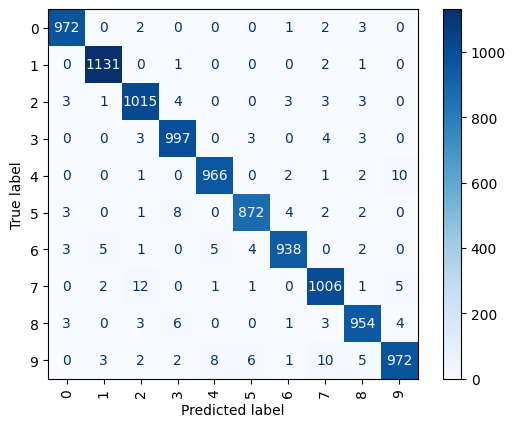

In [8]:
print(classification_report(y_pred=predictions, y_true=allLabels))
cm = confusion_matrix(allLabels, predictions)
ConfusionMatrixDisplay(cm).plot(cmap='Blues', xticks_rotation='vertical', values_format='d')

In [9]:
torch.save(model, './models/resnet50-pytorch.pt')